In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os, glob
from tqdm import tqdm
import torchvision
from torchvision import datasets, transforms
from matplotlib.pyplot import imshow
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [2]:
image_size = 224
batch_size = 16
num_workers = 4

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform_train = transforms.Compose([transforms.Resize((image_size, image_size), interpolation=Image.ANTIALIAS), \
                      transforms.RandomHorizontalFlip(),
                      transforms.ToTensor(), 
                      normalize])
transform_test = transforms.Compose([transforms.Resize((image_size, image_size), interpolation=Image.ANTIALIAS), \
                      transforms.ToTensor(), 
                      normalize])

data_train = datasets.ImageFolder('/scratch/rw2268/Handbag_brand/data/train', transform=transform_train)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                                         shuffle=True, 
                                                         num_workers=num_workers)

data_val = datasets.ImageFolder('/scratch/rw2268/Handbag_brand/data/val', transform=transform_test)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, 
                                                     shuffle=False, 
                                                     num_workers=num_workers)

data_test = datasets.ImageFolder('/scratch/rw2268/Handbag_brand/data/test', transform=transform_test)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, 
                                                       shuffle=False, 
                                                       num_workers=num_workers)

In [5]:
num_classes=len(train_loader.dataset.classes)
num_classes
train_loader.dataset.classes

['Louis_Vuitton',
 'balenciaga',
 'burberry',
 'chloe',
 'coach',
 'givenchy',
 'gucci',
 'longchamp',
 'michaelkors',
 'prada',
 'saint laurent',
 'unknown',
 'valentino']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


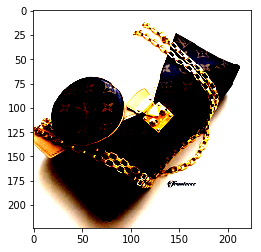

In [6]:
sp_img = data_train.__getitem__(345)[0].numpy()
# img = Image.fromarray(sp_img, 'RGB')
sp_img = sp_img.transpose([1,2,0])
imshow(sp_img)

## Load a pre-trained CNN and Train model

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
num_epochs = 10
num_epochs_decay = 60
learning_rate = 0.001
stop_training = 3
def update_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
def remove_layer(model, num_classes):
    modules = model.modules()
    for m in modules:
        if isinstance(m, nn.Linear) and m.weight.data.size()[0]==1000:
            w1 = m.weight.data[:num_classes]
            b1 = m.bias.data[:num_classes]
    try:
        if type(model.classifier)==nn.Sequential:
            mod = list(model.classifier) #Alexnet, VGG
        else:
            mod = [model.classifier] #DenseNet

    except: 
        mod = [model.fc] #ResNet

    weight = mod[-1].weight.size(1)
    mod.pop()
    mod.append(torch.nn.Linear(weight,num_classes))
    new_classifier = torch.nn.Sequential(*mod)
    model.classifier = new_classifier
    modules = model.modules()
    flag = False
    for m in modules:
        if isinstance(m, nn.Linear) and m.weight.data.size()[0]==num_classes:
            m.weight.data = w1
            m.bias.data = b1  
            flag = True
    assert flag

In [9]:
model = torchvision.models.resnet18(pretrained=True)
remove_layer(model, num_classes)

In [10]:
def save_model(model, name, epoch):
    dir_ = os.path.join('/scratch/rw2268/Handbag_brand/snapshot', name, '%s.pth'%(str(epoch).zfill(4)))
    create_folder(os.path.dirname(dir_))
    torch.save(model.state_dict(), dir_)
    print('!!Saving model: {}!'.format(dir_))
def create_folder(folder):
    if not os.path.isdir(folder):
        os.makedirs(folder)

In [11]:
def solver(name, data_loader, model, epoch, optimizer=None, mode='train'):
    model = model.to(device)
    if optimizer is None: model.eval()
    else: model.train()
    loss_cum = []
    Acc = 0
    count_test = 0
    test_out = []
    Loss = nn.CrossEntropyLoss()
    for batch_idx, (data,target) in tqdm(enumerate(data_loader), 
                total=len(data_loader), desc="!{} -> [{}] Epoch: {}".format(name.upper(), mode.upper(),epoch)):
        volatile = True if optimizer is None else False
        data = Variable(data.to(device), volatile=volatile)
        target = Variable(target.to(device), volatile=volatile)
       
        output = model(data)
        loss = Loss(output,target)   
        
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       

        loss_cum.append(loss.data.cpu()[0])
        _, arg_max_out = torch.max(output.data.cpu(), 1)
      
        if mode=='test':
            for oo in arg_max_out:
                test_out.append('%s,%d\n'%(str(count_test).zfill(4), oo))
                count_test+=1

        Acc += arg_max_out.long().eq(target.data.cpu().long()).sum()
#         if batch_idx % 20 == 0:
#             print('Epoch:{}, batch:{}, Acc:{}'.format(epoch+1,batch_idx+1,Acc*100/)
    ACC = float(Acc*100)/len(data_loader.dataset)
    LOSS = np.array(loss_cum).mean()
    if mode=='test':
        f=open(os.path.join('snapshot', name, 'test.txt'),'w')
        for line in test_out: f.writelines(line)
        f.close()
    else:
        print("LOSS %s: %0.3f || ACC %s: %0.2f"%(mode.upper(), LOSS, mode.upper(), ACC))
    
    return ACC

#==========================================================================#
def train(name,train_loader, val_loader, model, learning_rate=learning_rate):
    val_before = 0
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, [0.5, 0.999])
    model.train()
    for epoch in range(num_epochs):
        solver(name, train_loader, model, epoch, optimizer=optimizer, mode='train')
        val_acc = solver(name, val_loader, model, epoch, mode='val')
        if val_acc>val_before:
            save_model(model, name, epoch+1)
            val_before=val_acc
            flag_stop=0
        else:
            flag_stop+=1

        if flag_stop==stop_training: 
            return

    # Decay learning rate
        if (epoch+1) > (num_epochs - num_epochs_decay):
            learning_rate -= (learning_rate / float(num_epochs_decay))
            update_lr(learning_rate, optimizer)
            print ('Decay learning rate to: {}.'.format(learning_rate))

In [12]:
train('ResNet18',train_loader, val_loader, model)

!RESNET18 -> [TRAIN] Epoch: 0: 100%|██████████| 314/314 [03:39<00:00,  1.43it/s]

LOSS TRAIN: 1.877 || ACC TRAIN: 44.56



!RESNET18 -> [VAL] Epoch: 0: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


LOSS VAL: 1.989 || ACC VAL: 44.50
!!Saving model: /scratch/rw2268/Handbag_brand/snapshot/ResNet18/0001.pth!
Decay learning rate to: 0.0009833333333333335.


!RESNET18 -> [TRAIN] Epoch: 1: 100%|██████████| 314/314 [03:24<00:00,  1.54it/s]

LOSS TRAIN: 1.223 || ACC TRAIN: 63.02



!RESNET18 -> [VAL] Epoch: 1: 100%|██████████| 50/50 [00:30<00:00,  1.63it/s]

LOSS VAL: 1.371 || ACC VAL: 58.03
!!Saving model: /scratch/rw2268/Handbag_brand/snapshot/ResNet18/0002.pth!
Decay learning rate to: 0.0009669444444444445.



!RESNET18 -> [TRAIN] Epoch: 2: 100%|██████████| 314/314 [03:24<00:00,  1.31it/s]

LOSS TRAIN: 1.007 || ACC TRAIN: 69.66



!RESNET18 -> [VAL] Epoch: 2: 100%|██████████| 50/50 [00:30<00:00,  2.49it/s]

LOSS VAL: 1.390 || ACC VAL: 57.14
Decay learning rate to: 0.0009508287037037038.



!RESNET18 -> [TRAIN] Epoch: 3: 100%|██████████| 314/314 [03:24<00:00,  1.54it/s]

LOSS TRAIN: 0.851 || ACC TRAIN: 74.11



!RESNET18 -> [VAL] Epoch: 3: 100%|██████████| 50/50 [00:30<00:00,  1.63it/s]

LOSS VAL: 1.397 || ACC VAL: 58.91
!!Saving model: /scratch/rw2268/Handbag_brand/snapshot/ResNet18/0004.pth!
Decay learning rate to: 0.0009349815586419754.



!RESNET18 -> [TRAIN] Epoch: 4: 100%|██████████| 314/314 [03:25<00:00,  1.53it/s]

LOSS TRAIN: 0.709 || ACC TRAIN: 78.22



!RESNET18 -> [VAL] Epoch: 4: 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]

LOSS VAL: 1.311 || ACC VAL: 62.20
!!Saving model: /scratch/rw2268/Handbag_brand/snapshot/ResNet18/0005.pth!
Decay learning rate to: 0.0009193985326646091.



!RESNET18 -> [TRAIN] Epoch: 5: 100%|██████████| 314/314 [03:24<00:00,  1.53it/s]

LOSS TRAIN: 0.610 || ACC TRAIN: 81.07



!RESNET18 -> [VAL] Epoch: 5: 100%|██████████| 50/50 [00:30<00:00,  1.63it/s]

LOSS VAL: 1.574 || ACC VAL: 58.41
Decay learning rate to: 0.0009040752237868656.



!RESNET18 -> [TRAIN] Epoch: 6: 100%|██████████| 314/314 [03:24<00:00,  1.35it/s]

LOSS TRAIN: 0.476 || ACC TRAIN: 85.56



!RESNET18 -> [VAL] Epoch: 6: 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]

LOSS VAL: 1.316 || ACC VAL: 65.11
!!Saving model: /scratch/rw2268/Handbag_brand/snapshot/ResNet18/0007.pth!
Decay learning rate to: 0.0008890073033904179.



!RESNET18 -> [TRAIN] Epoch: 7: 100%|██████████| 314/314 [03:25<00:00,  1.53it/s]

LOSS TRAIN: 0.413 || ACC TRAIN: 87.55



!RESNET18 -> [VAL] Epoch: 7: 100%|██████████| 50/50 [00:30<00:00,  1.63it/s]

LOSS VAL: 1.638 || ACC VAL: 60.43
Decay learning rate to: 0.0008741905150005775.



!RESNET18 -> [TRAIN] Epoch: 8: 100%|██████████| 314/314 [03:25<00:00,  2.14it/s]

LOSS TRAIN: 0.333 || ACC TRAIN: 89.67



!RESNET18 -> [VAL] Epoch: 8: 100%|██████████| 50/50 [00:30<00:00,  2.33it/s]

LOSS VAL: 1.418 || ACC VAL: 63.84
Decay learning rate to: 0.0008596206730839012.



!RESNET18 -> [TRAIN] Epoch: 9: 100%|██████████| 314/314 [03:24<00:00,  2.58it/s]

LOSS TRAIN: 0.283 || ACC TRAIN: 90.69



!RESNET18 -> [VAL] Epoch: 9: 100%|██████████| 50/50 [00:30<00:00,  1.71it/s]

LOSS VAL: 1.469 || ACC VAL: 65.11


In [30]:
device

device(type='cuda', index=0)